In [12]:
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
from ivis import Ivis 

from rpy2.robjects import r

In [13]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


### Simulate cell groups from different batches

In [15]:
%%R -o counts -o cells -o batch

suppressMessages(library(splatter))

params <- newSplatParams()

params <- setParam(params, "nGenes", 2000)
params <- setParam(params, "batchCells", c(1000, 1000, 2000))
params <- setParam(params, "batch.facLoc", 0.3)
params <- setParam(params, "batch.facScale", 0.3)
params <- setParam(params, "group.prob", c(1/4, 1/4, 1/4, 1/4))

sim <- splatSimulate(params, method="groups", verbose=FALSE)

counts <- data.frame(counts(sim))
cells <- colData(sim)[,"Group"]
batch <- colData(sim)[,"Batch"]

In [16]:
counts = np.array(counts)
meta = pd.DataFrame({'cells': cells, 'batch': batch} , dtype="str", index = range(0, len(cells)))

In [17]:
adata = ad.AnnData(X = counts.T, obs = meta)
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_neighbors=10)
sc.tl.umap(adata)

Transforming to str index.


In [18]:
adata.uns["batch_colors"] = ["#9b59b6", "#3498db", "#95a5a6"]

### Run standard UMAP

... storing 'cells' as categorical
... storing 'batch' as categorical


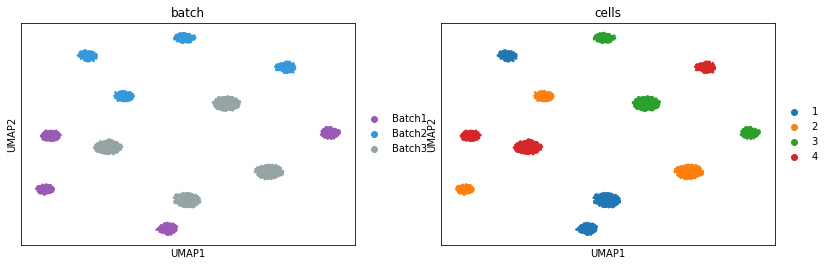

In [19]:
adata_umap = adata.copy()
sc.pl.umap(adata,color=['batch','cells'])

In [20]:
adata = adata[np.random.choice(adata.obs_names, adata.shape[0], replace = False)]

### Run IVIS

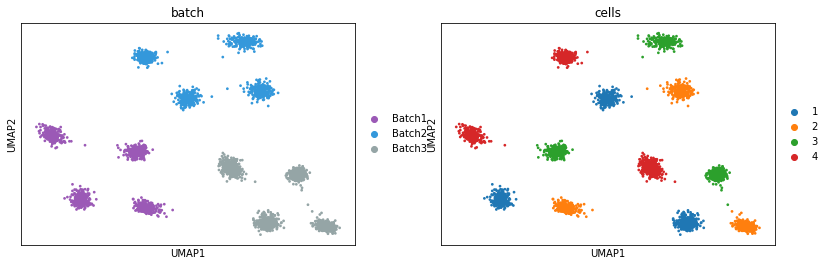

Wall time: 57.9 s


In [21]:
%%time
adata_ivis = adata.copy()
X = adata_ivis.obsm["X_pca"]
model = Ivis(k = 50, model = 'szubert', verbose=0, n_epochs_without_progress = 5)
model.fit(X)
adata_ivis.obsm["X_umap"] = model.transform(X)
sc.pl.umap(adata_ivis, color = ["batch", "cells"])

### Run TNN

In [22]:
from bbtnn.tnn_v3 import *

In [23]:
%%time
adata_tnn = adata.copy()
model = TNN(k = 50, batch_size = 32, n_epochs_without_progress = 5, verbose = 0)
model.fit(X = adata, batch_name = "batch", Y = None)
embedding = model.transform(X = adata)

Processing datasets (0, 1)
new function
new function
Processing datasets (0, 2)
new function
new function
Processing datasets (1, 2)
new function
new function
Wall time: 52.4 s


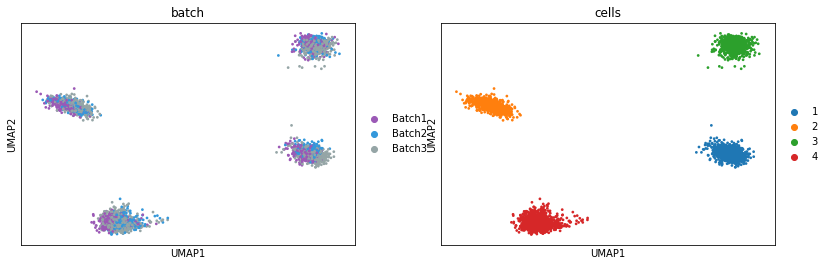

In [26]:
adata_tnn.obsm["X_umap"] = embedding
sc.pl.umap(adata_tnn, color = ["batch", "cells"])

### Compile into one figure

In [28]:
sc.set_figure_params(dpi_save = 300)
sc.settings.figdir = "/Users/lsimon/OneDrive/Miko/UTHealth/projects/BatchBalancedTriplets/figures/"

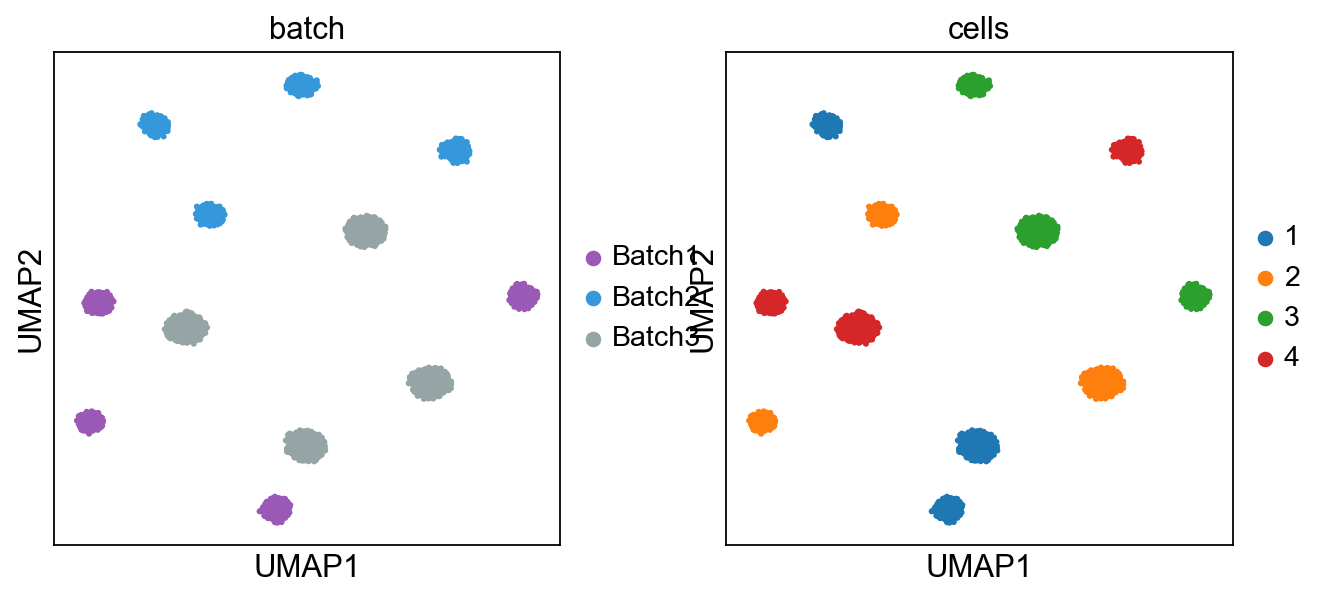

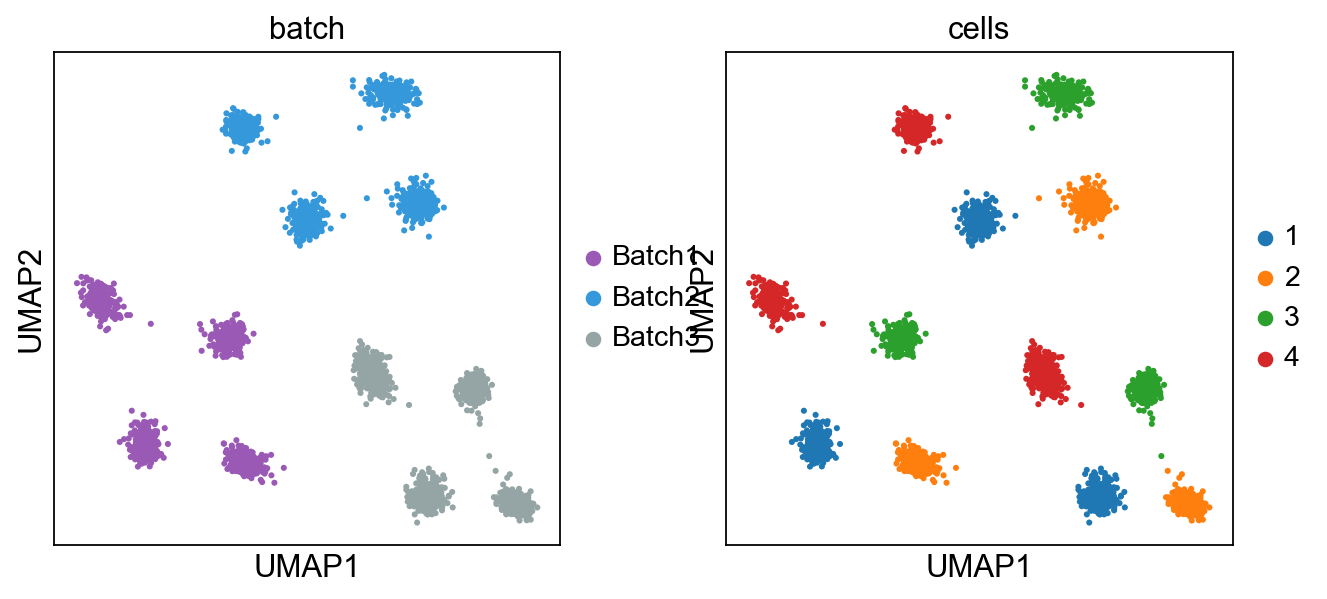

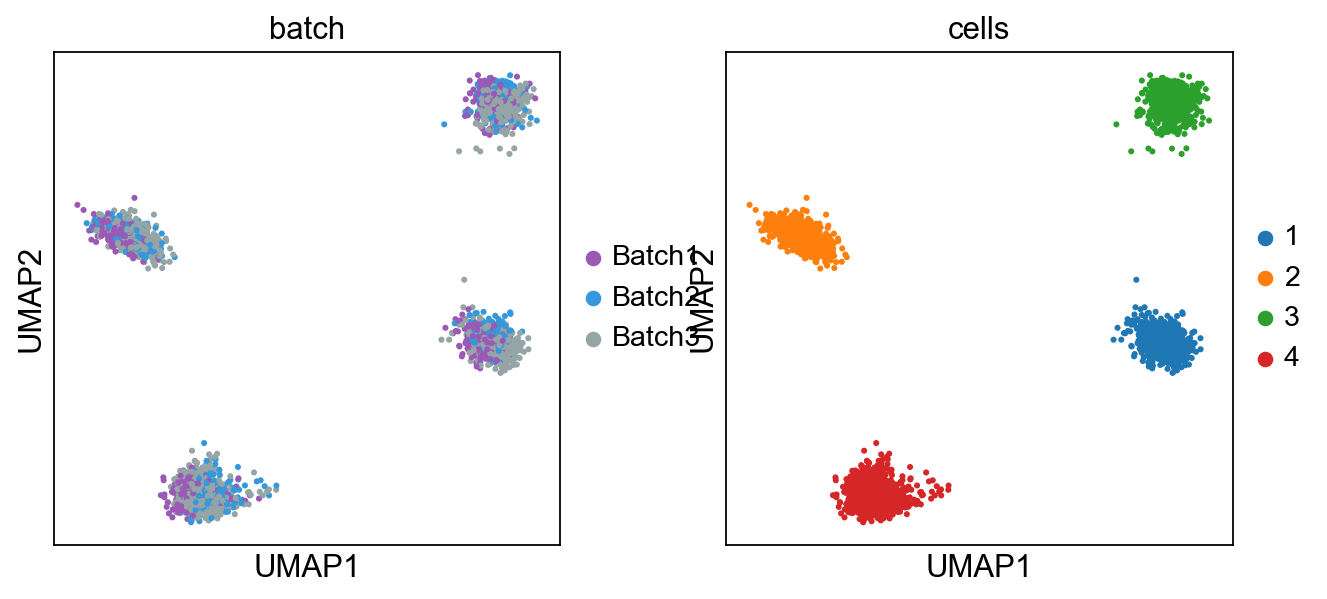

In [29]:
sc.pl.umap(adata_umap, color = ["batch", "cells"], save = "_sim1_standard.pdf")
sc.pl.umap(adata_ivis, color = ["batch", "cells"], save = "_sim1_ivis.pdf")
sc.pl.umap(adata_tnn, color = ["batch", "cells"], save = "_sim1_tnn.pdf")

### Generate a cell group exclusive to one batch

In [30]:
bdata = adata[~((adata.obs["batch"] == "Batch1") & (adata.obs["cells"] =="4"))]
bdata = bdata[~((bdata.obs["batch"] == "Batch2") & (bdata.obs["cells"] =="4"))]

In [31]:
bdata

View of AnnData object with n_obs × n_vars = 3481 × 2000 
    obs: 'cells', 'batch', 'n_counts'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'batch_colors', 'cells_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [32]:
sc.tl.pca(bdata)
sc.pp.neighbors(bdata, n_neighbors=50)
sc.tl.umap(bdata)
bdata_umap = bdata.copy()

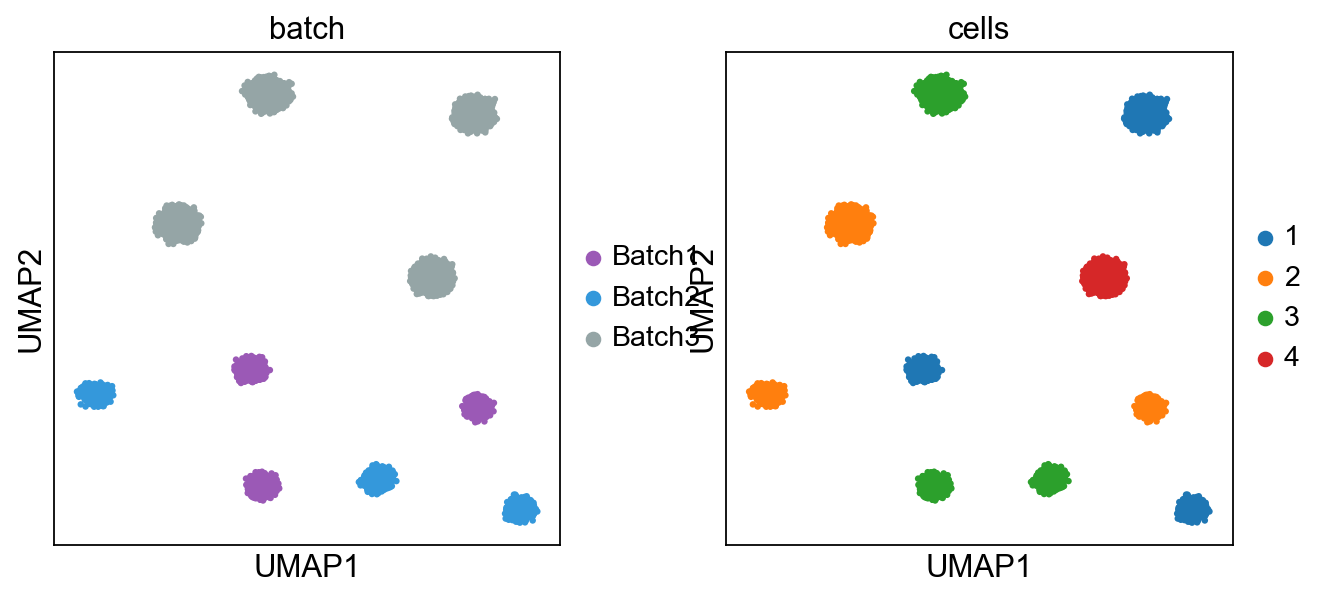

In [33]:
sc.pl.umap(bdata_umap, color = ["batch", "cells"])

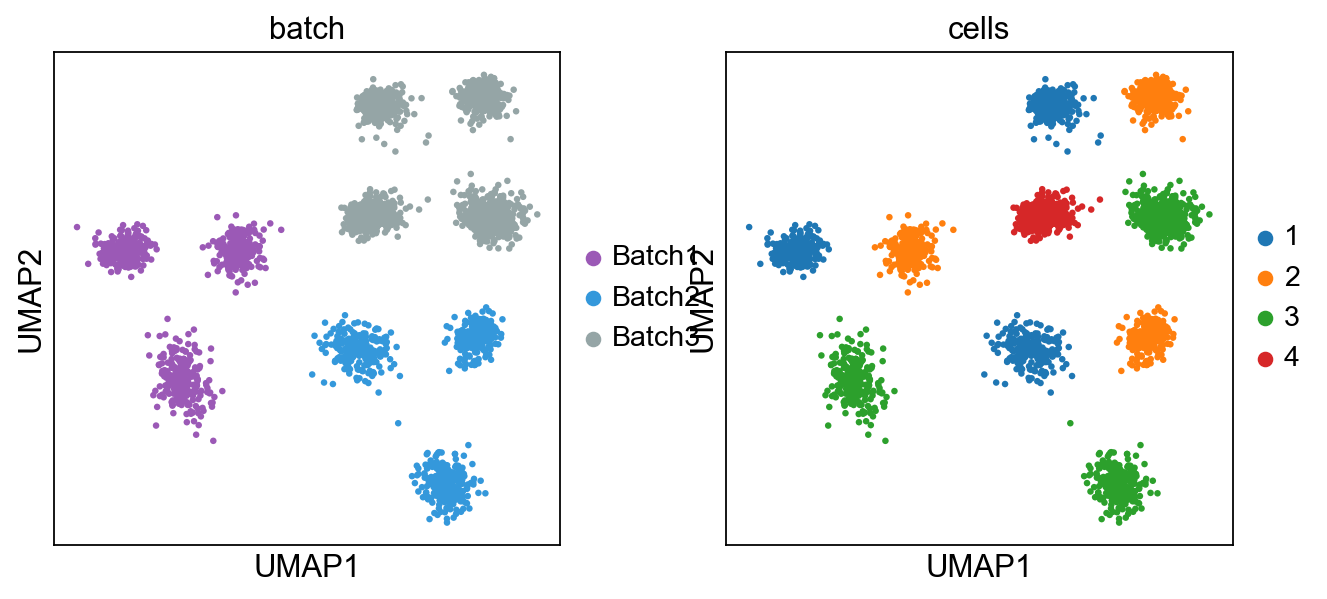

Wall time: 48.4 s


In [34]:
%%time
bdata_ivis = bdata.copy()
X = bdata_ivis.obsm["X_pca"]
model = Ivis(k = 50, model = 'szubert', verbose=0, n_epochs_without_progress = 5)
model.fit(X)
bdata_ivis.obsm["X_umap"] = model.transform(X)
sc.pl.umap(bdata_ivis, color = ["batch", "cells"])

In [36]:
%%time
bdata_tnn = bdata.copy()
model = TNN(k = 50, batch_size = 32, n_epochs_without_progress = 5, verbose = 0)
model.fit(X = bdata_tnn, batch_name = "batch", Y = None)
embedding = model.transform(X = bdata_tnn)

Processing datasets (0, 1)
new function
new function
Processing datasets (0, 2)
new function
new function
Processing datasets (1, 2)
new function
new function
Wall time: 1min 10s


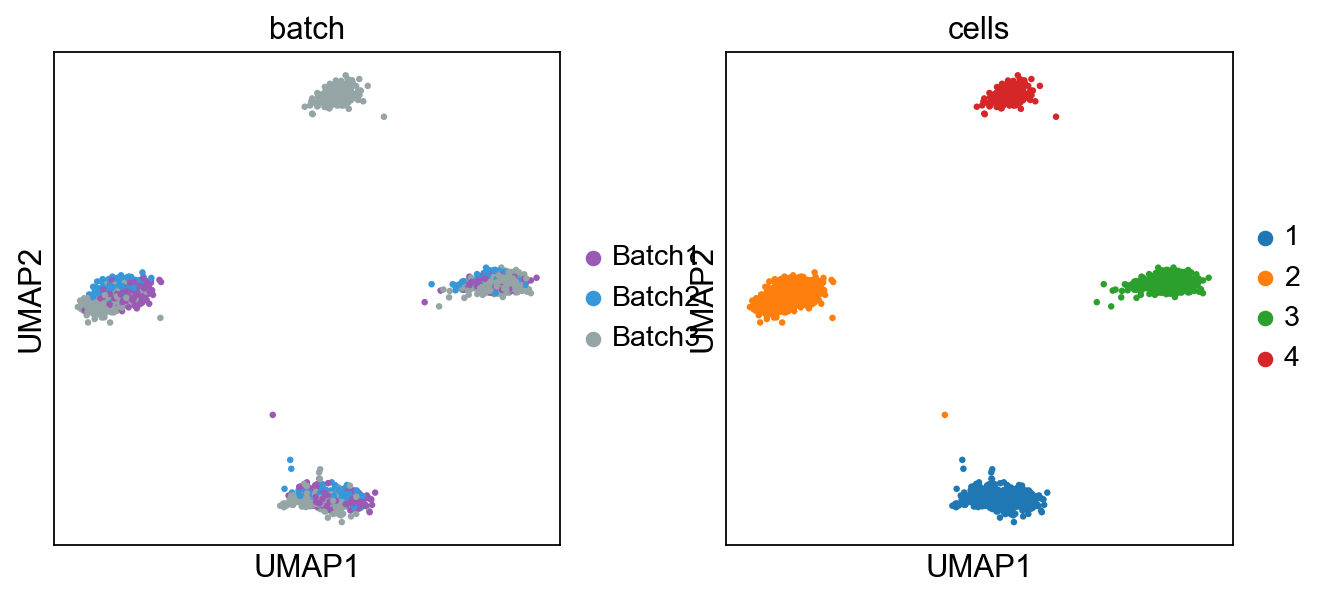

In [37]:
bdata_tnn.obsm["X_umap"] = embedding
sc.pl.umap(bdata_tnn, color = ["batch", "cells"])

### Compile into one figure

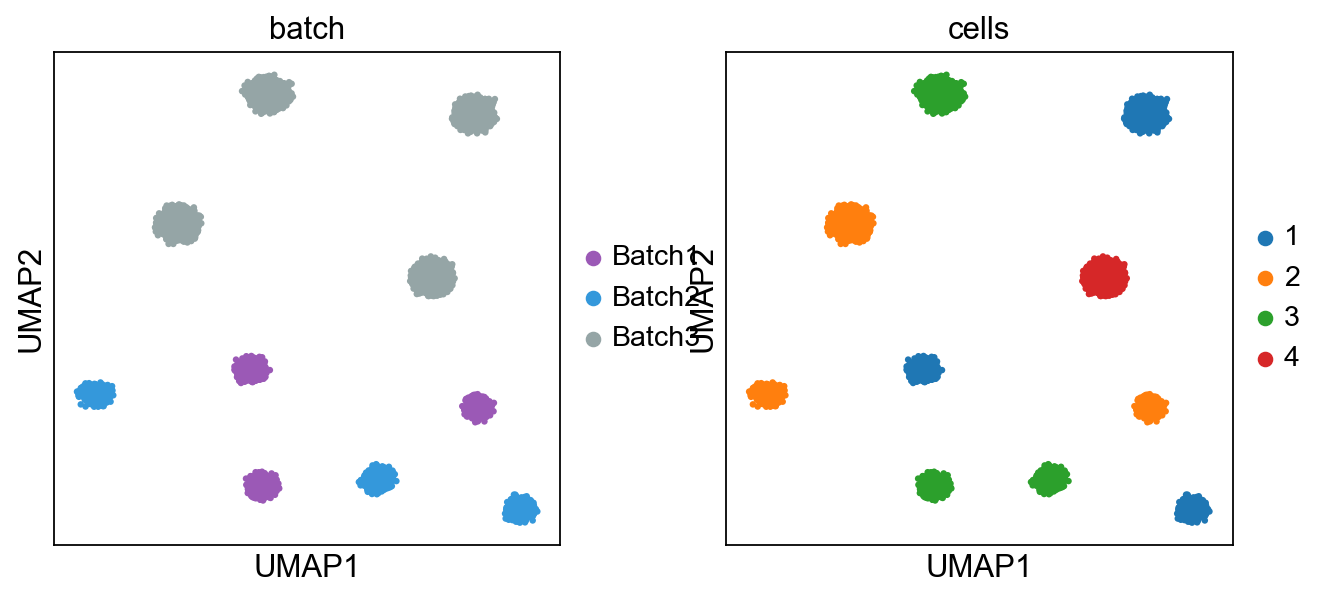

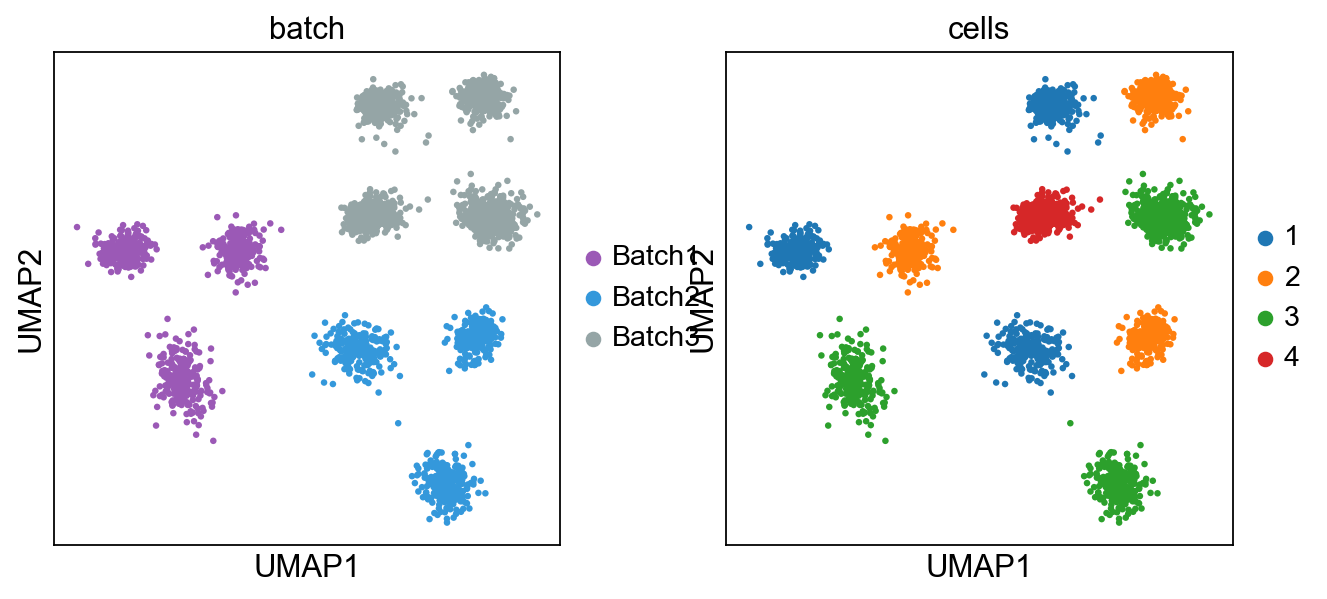

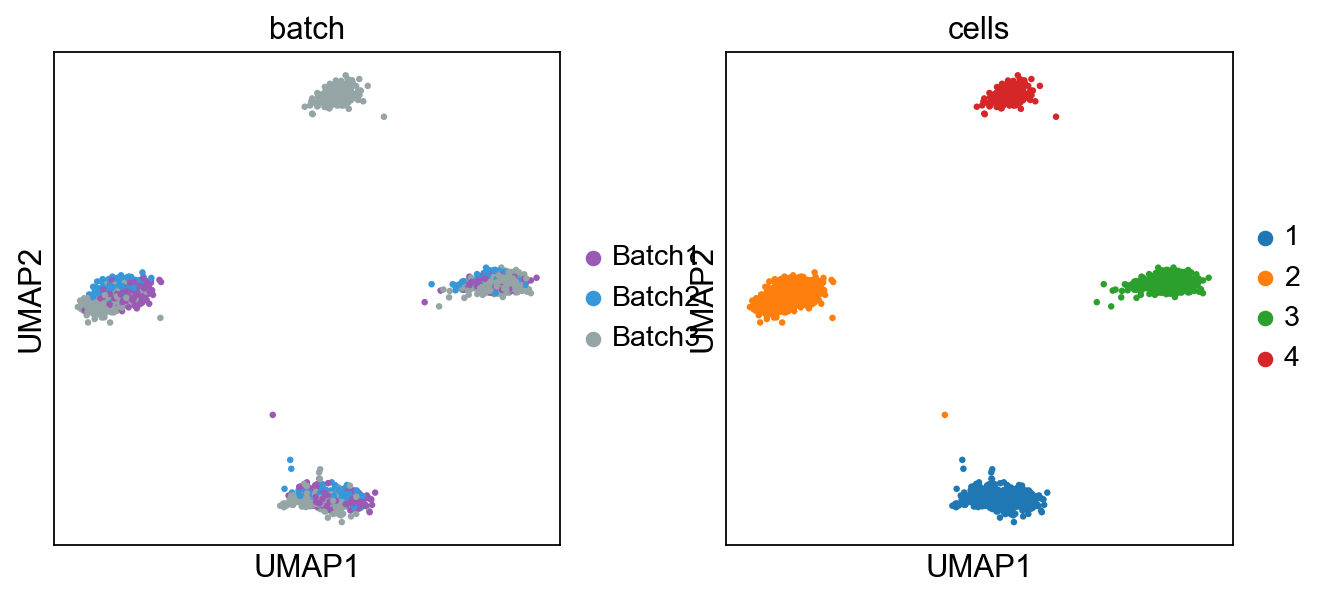

In [38]:
sc.pl.umap(bdata_umap, color = ["batch", "cells"], save = "_sim2_standard.pdf")
sc.pl.umap(bdata_ivis, color = ["batch", "cells"], save = "_sim2_ivis.pdf")
sc.pl.umap(bdata_tnn, color = ["batch", "cells"], save = "_sim2_tnn.pdf")